Засоби підготовки та аналізу даних

Лабораторна робота №7 Сценарії обробки багатоспектральних супутникових зображень

Мета роботи: ознайомитися з основними принципами обробки даних дистанційного зондування Землі (ДЗЗ) та можливостями мови Python для обробки геопросторової інформації, а саме, багатоспектральних супутникових зображень засобами бібліотеки абстракції супутникової інформації (GDAL).

## Sentinel-2

In [1]:
import os
import shutil
import zipfile
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
from rasterio.plot import show

print("Бібліотеки імпортовано, все ок!")

Бібліотеки імпортовано, все ок!


КРОК 1: Розпаковка архівів Sentinel-2

In [2]:
archives = [
    "C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.zip",
    "C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.zip"
]

def extract(archives):
    for archive_path in archives:
        extract_dir = os.path.splitext(archive_path)[0]  # без .zip
        if os.path.exists(extract_dir):
            shutil.rmtree(extract_dir)
            print(f"Видалено наявний каталог: {extract_dir}")
        os.makedirs(extract_dir, exist_ok=True)
        print(f"Створено новий каталог: {extract_dir}")
        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
            print(f"Розпаковано: {archive_path}")

extract(archives)
print("Усі архіви успішно розпаковано.\n")

Видалено наявний каталог: C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206
Створено новий каталог: C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206
Розпаковано: C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.zip
Видалено наявний каталог: C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206
Створено новий каталог: C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206
Розпаковано: C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.zip
Усі архіви успішно розпаковано.



In [3]:
sentinel_dirs = [
    "C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206",
    "C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206"
]
sentinel_bands = ['B02', 'B03', 'B04', 'B8A']

def find_band_files(root_dir, bands):
    band_files = []
    for subdir, dirs, files in os.walk(root_dir):
        if 'IMG_DATA' in subdir and 'R60m' in subdir:
            for band in bands:
                match = [os.path.join(subdir, f) for f in files if band in f and f.endswith('.jp2')]
                if match:
                    band_files.append(match[0])
    return band_files

sentinel_band_paths = []
for folder in sentinel_dirs:
    bands_found = find_band_files(folder, sentinel_bands)
    print(f"Для {os.path.basename(folder)} знайдено канали:\n", bands_found)
    sentinel_band_paths.append(bands_found)


Для S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206 знайдено канали:
 ['C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206\\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE\\GRANULE\\L2A_T36UUB_A021740_20190821T085815\\IMG_DATA\\R60m\\T36UUB_20190821T085601_B02_60m.jp2', 'C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206\\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE\\GRANULE\\L2A_T36UUB_A021740_20190821T085815\\IMG_DATA\\R60m\\T36UUB_20190821T085601_B03_60m.jp2', 'C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206\\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE\\GRANULE\\L2A_T36UUB_A021740_20190821T085815\\IMG_DATA\\R60m\\T36UUB_20190821T085601_B04_60m.jp2', 'C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206\\S2A_MSIL2A_20190821T085601_N0

Конкатенація

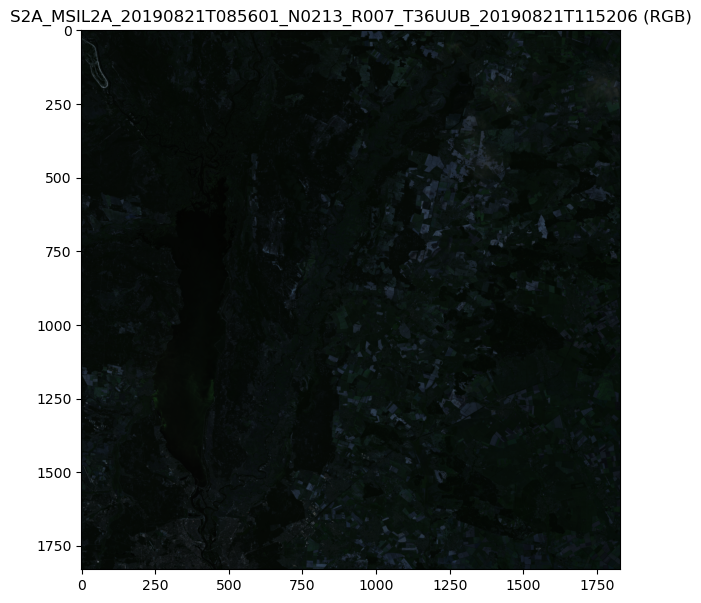

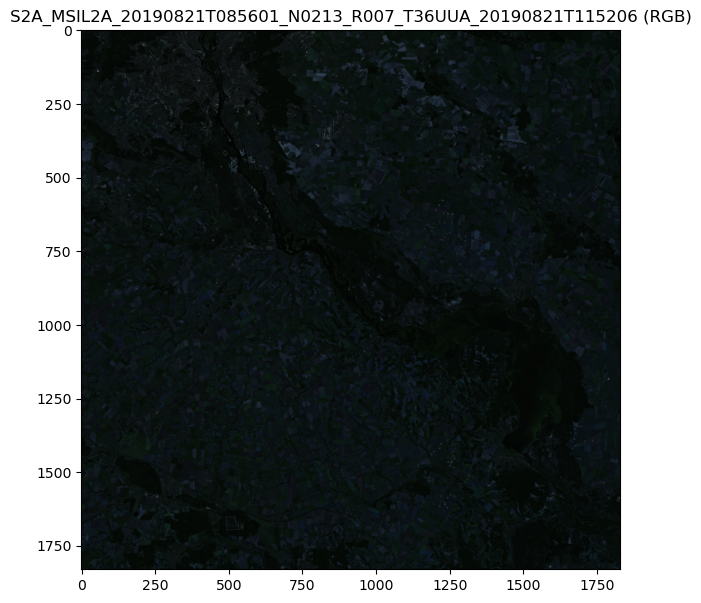

In [4]:
WORKDIR = "ad_lab7"
bands_s2 = ["B02", "B03", "B04", "B8A"]
shapefile = f"{WORKDIR}/Kyiv_regions.shp"
sentinel_granules = [os.path.splitext(a)[0] for a in archives]

for granule in sentinel_granules:
    jp2_dir = None
    for root, dirs, files in os.walk(granule):
        if "R60m" in root:
            jp2_dir = root
            break
    if not jp2_dir:
        print(f"Не знайдено папку R60m в {granule}")
        continue

    band_paths = []
    for band in bands_s2:
        found = [f for f in os.listdir(jp2_dir) if band in f and f.endswith(".jp2")]
        if found:
            band_paths.append(os.path.join(jp2_dir, found[0]))
        else:
            print(f"Канал {band} не знайдено у {jp2_dir}")

    if len(band_paths) != 4:
        print(f"Не всі канали знайдено для {granule}, пропуск.")
        continue

    output_tif = os.path.join(granule, "merged.tif")
    gdal_merge = os.path.join(sys.prefix, "Scripts", "gdal_merge.py")
    cmd = ["python", gdal_merge, "-separate", "-o", output_tif] + band_paths
    subprocess.run(cmd)
    # print(f"Готово: {output_tif}")

    # візуалізація
    with rasterio.open(output_tif) as src:
        rgb = src.read([1, 2, 3])
        rgb_norm = np.clip(rgb.transpose(1, 2, 0) / 10000, 0, 1)
        plt.figure(figsize=(7, 7))
        plt.imshow(rgb_norm)
        plt.title(f"{os.path.basename(granule)} (RGB)")
        plt.show()


Перепроектування супутникового зображення у проєкцію 4326.

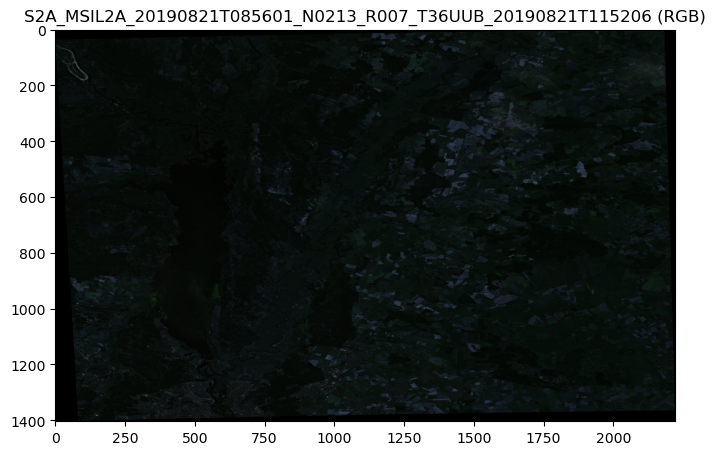

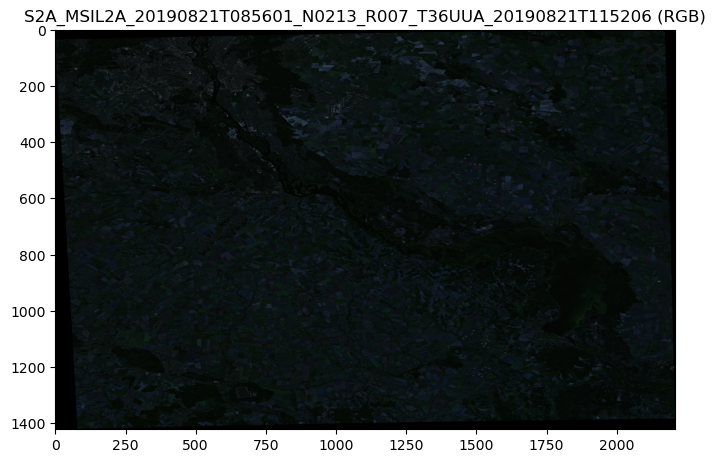

In [5]:
granules = [
    "C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206",
    "C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206"
]

reprojected_files = []

for granule in granules:
    input_file = os.path.join(granule, "merged.tif")
    output_file = os.path.join(granule, "reprojected.tif")

    cmd = [
        "gdalwarp",
        "-s_srs", "EPSG:32636",  # початкова проекція (UTM Zone 36N)
        "-t_srs", "EPSG:4326",   # фінальна (WGS84)
        input_file,
        output_file
    ]
    subprocess.run(cmd)
    # print(f"Перепроектовано: {output_file}")
    reprojected_files.append(output_file)

    try:
        with rasterio.open(output_file) as src:
            rgb = src.read([1, 2, 3])
            rgb_norm = np.clip(rgb.transpose(1, 2, 0) / 10000, 0, 1)
            plt.figure(figsize=(8, 8))
            plt.imshow(rgb_norm)
            plt.title(f"{os.path.basename(granule)} (RGB)")
            plt.show()
    except Exception as e:
        print(f"Не вдалося відкрити {output_file}: {e}")

Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.

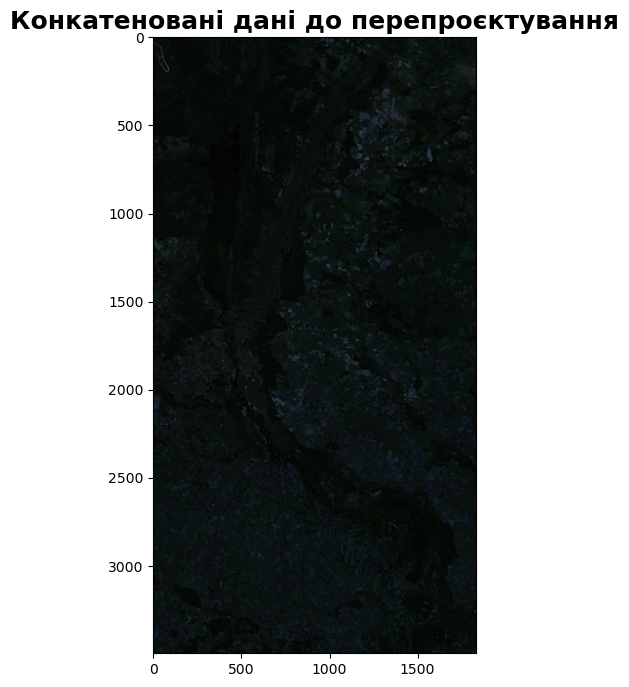

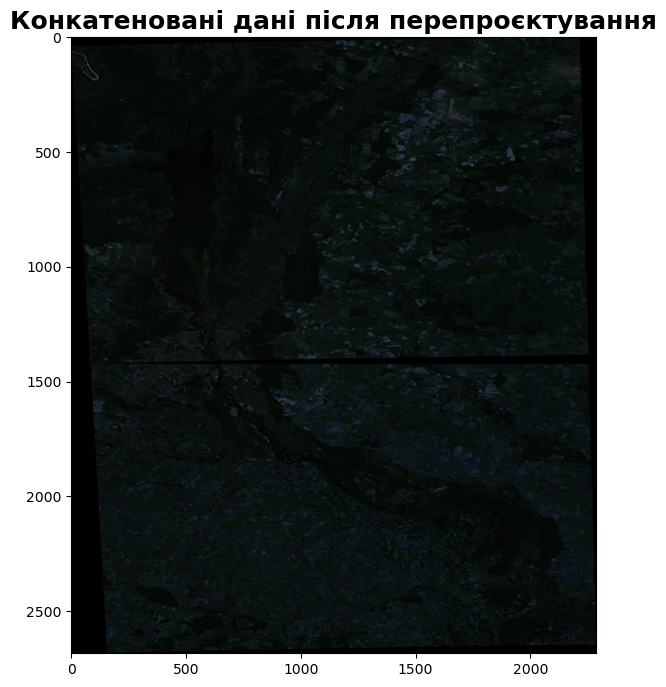

In [6]:
merged_tifs = [
    "C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206/merged.tif",
    "C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206/merged.tif"
]

# папка для збереження результату
concat_dir = "C:/Users/Hello/Documents/ad_lab7_t/sentinel_concat"
os.makedirs(concat_dir, exist_ok=True)
output_tif = os.path.join(concat_dir, "general.tif")

# конкатенація у 4-канальний TIFF
gdal_merge = os.path.join(sys.prefix, "Scripts", "gdal_merge.py")
cmd = ["python", gdal_merge, "-separate", "-o", output_tif] + merged_tifs
# print(" ".join(cmd))
subprocess.run(cmd)
# print(f"Конкатенація завершена: {output_tif}")

try:
    with rasterio.open(output_tif) as src:
        # print(f"Кількість каналів у файлі: {src.count}")
        rgb = src.read([1, 2, 3])
        rgb_norm = np.clip(rgb.transpose(1, 2, 0) / 10000, 0, 1)
        plt.figure(figsize=(8, 8))
        plt.title("Конкатеновані дані до перепроєктування", fontsize=18, weight='bold')
        plt.imshow(rgb_norm)
        plt.axis("on")
        plt.show()
except Exception as e:
    print(f"Не вдалося відкрити або обробити {output_tif}: {e}")

reprojected_tifs = [
    "C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206/reprojected.tif",
    "C:/Users/Hello/Documents/ad_lab7_t/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206/reprojected.tif"
]

# папка для збереження результату
concat_dir = "C:/Users/Hello/Documents/ad_lab7_t/sentinel_concat"
os.makedirs(concat_dir, exist_ok=True)
output_proj_tif = os.path.join(concat_dir, "general4326.tif")

gdal_merge = os.path.join(sys.prefix, "Scripts", "gdal_merge.py")
cmd = ["python", gdal_merge, "-separate", "-o", output_proj_tif] + reprojected_tifs
# print(" ".join(cmd))
subprocess.run(cmd)
# print(f"Конкатенація після перепроєктування завершена: {output_proj_tif}")

try:
    with rasterio.open(output_proj_tif) as src:
        # print(f"Кількість каналів у файлі: {src.count}")
        rgb = src.read([1, 2, 3])
        rgb_norm = np.clip(rgb.transpose(1, 2, 0) / 10000, 0, 1)
        plt.figure(figsize=(8, 8))
        plt.title("Конкатеновані дані після перепроєктування", fontsize=18, weight='bold')
        plt.imshow(rgb_norm)
        plt.axis("on")
        plt.show()
except Exception as e:
    print(f"Не вдалося відкрити або обробити {output_proj_tif}: {e}")

Обрізання по шейпу

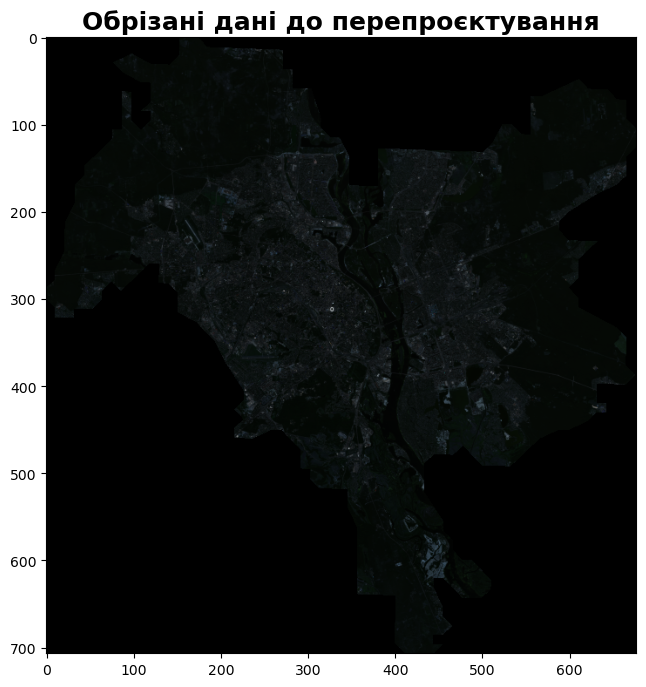

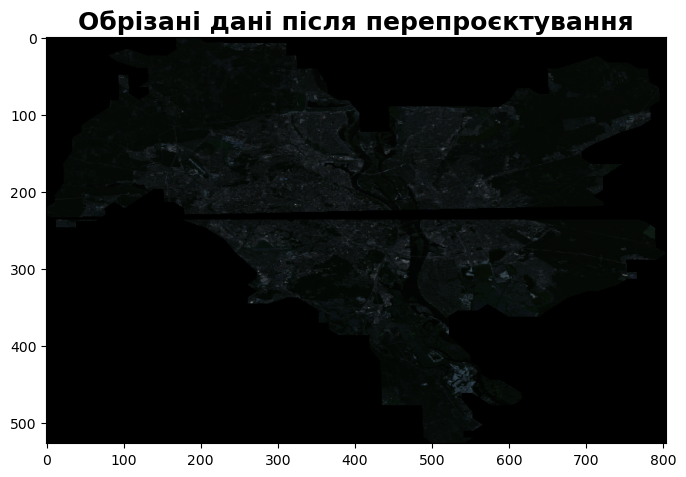

In [7]:
base_dir = "C:/Users/Hello/Documents/ad_lab7_t/sentinel_concat"
shapefile = "C:/Users/Hello/Documents/ad_lab7_t/Kyiv_regions.shp"

# вихідні 
input_tifs = [
    os.path.join(base_dir, "general.tif"),         # до перепроєкції
    os.path.join(base_dir, "general4326.tif")      # після перепроєкції
]
clipped_tifs = [
    os.path.join(base_dir, "clipped_general.tif"),
    os.path.join(base_dir, "clipped_general4326.tif")
]
titles = [
    "Обрізані дані до перепроєктування",
    "Обрізані дані після перепроєктування"
]

for input_tif, clipped_tif, title in zip(input_tifs, clipped_tifs, titles):
    # обрізання по шейпу
    cmd = [
        "gdalwarp",
        "-cutline", shapefile,
        "-crop_to_cutline",
        input_tif,
        clipped_tif
    ]
    # print(" ".join(cmd))
    subprocess.run(cmd)
    # print(f"Обрізано: {clipped_tif}")

    # візуалізація
    try:
        with rasterio.open(clipped_tif) as src:
            # print(f"Кількість каналів у файлі: {src.count}")
            rgb = src.read([1, 2, 3])
            rgb_norm = np.clip(rgb.transpose(1, 2, 0) / 10000, 0, 1)
            plt.figure(figsize=(8, 8))
            plt.title(title, fontsize=18, weight='bold')
            plt.imshow(rgb_norm)
            plt.axis("on")
            plt.show()
    except Exception as e:
        print(f"Не вдалося відкрити або обробити {clipped_tif}: {e}")


## Landsat 

Завантажуємо файли з сайту 

Зконкатеновано: C:/Users/Hello/Documents/ad_lab7_t/Landset/181025\scene_stack.tif
Зконкатеновано: C:/Users/Hello/Documents/ad_lab7_t/Landset/182025\scene_stack.tif


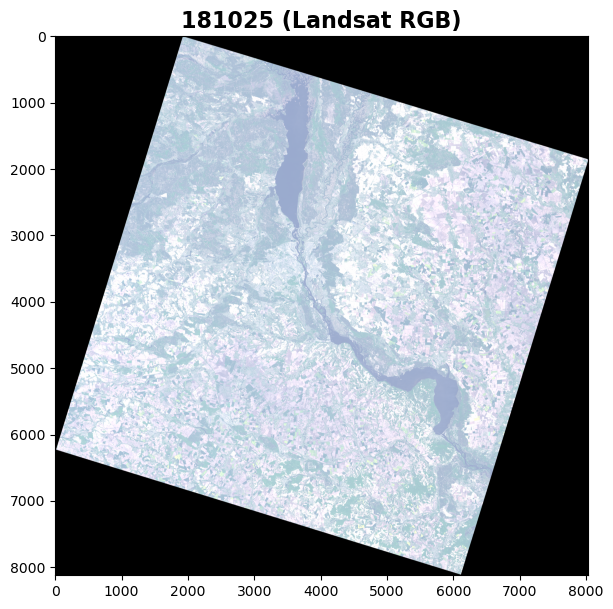

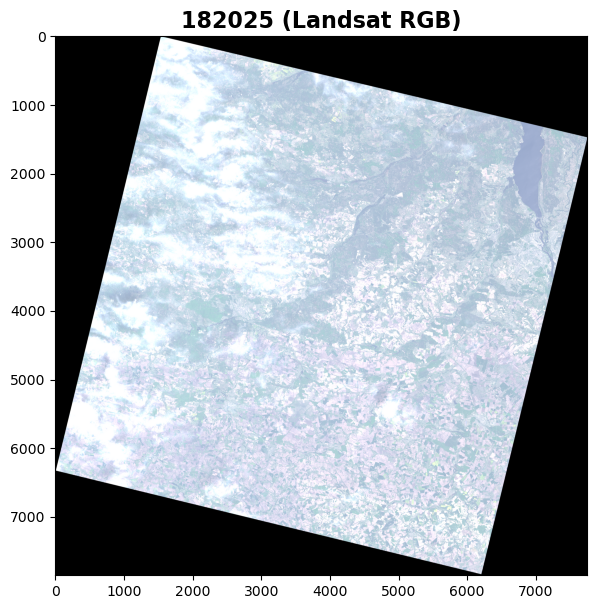

In [8]:
landsat_dirs = [
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/181025",
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/182025",
]
bands = ["B2", "B3", "B4", "B8"]

file_patterns = {
    "181025": "LC08_L1TP_181025_20240430_20240511_02_T1_{band}.TIF",
    "182025": "LC09_L1TP_182025_20240429_20240429_02_T1_{band}.TIF",
}

for d in landsat_dirs:
    basename = os.path.basename(d)
    pattern = file_patterns[basename]
    tif_files = [os.path.join(d, pattern.format(band=band)) for band in bands]
    # print("TIFs:", tif_files)
    missing = [f for f in tif_files if not os.path.exists(f)]
    if missing:
        print(f"Не знайдено файл(и): {missing}")
        continue

    output = os.path.join(d, "scene_stack.tif")
    merge_cmd = [
        "python",
        os.path.join(sys.prefix, "Scripts", "gdal_merge.py"),
        "-separate", "-o", output
    ] + tif_files
    # print("CMD:", " ".join(merge_cmd))
    subprocess.run(merge_cmd)
    print(f"Зконкатеновано: {output}")

# візуалізація RGB для кожної сцени
for d in landsat_dirs:
    stack_file = os.path.join(d, "scene_stack.tif")
    try:
        with rasterio.open(stack_file) as src:
            rgb = src.read([3, 2, 1])
            rgb_norm = np.clip(rgb.transpose(1, 2, 0) / 10000, 0, 1)
            plt.figure(figsize=(7, 7))
            plt.title(f"{os.path.basename(d)} (Landsat RGB)", fontsize=16, weight="bold")
            plt.imshow(rgb_norm)
            plt.axis("on")
            plt.show()
    except Exception as e:
        print(f"Не вдалося відкрити {stack_file}: {e}")


2. Конкатенуємо в одне зображення

CMD: python d:\anaconda\envs\lab7\Scripts\gdal_merge.py -separate -o C:/Users/Hello/Documents/ad_lab7_t/Landset/final_merged.tif C:/Users/Hello/Documents/ad_lab7_t/Landset/181025\scene_stack.tif C:/Users/Hello/Documents/ad_lab7_t/Landset/182025\scene_stack.tif
Конкатенація завершена: C:/Users/Hello/Documents/ad_lab7_t/Landset/final_merged.tif
Не вдалося відкрити або обробити C:/Users/Hello/Documents/ad_lab7_t/Landset/final_merged.tif: Unable to allocate 3.36 GiB for an array with shape (8121, 18501, 3) and data type float64


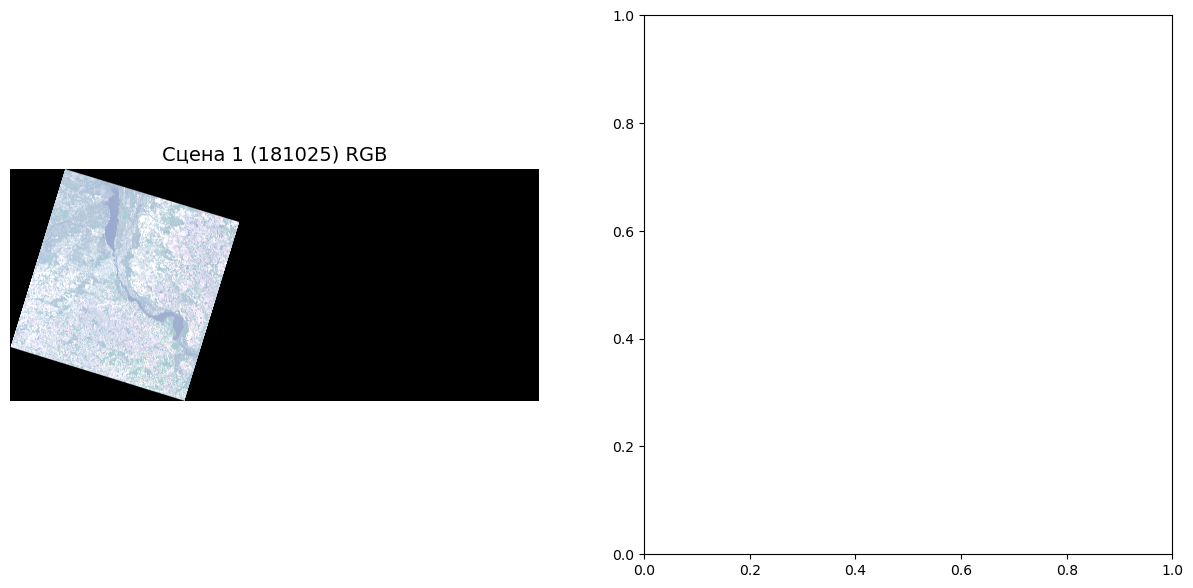

In [ ]:
# шляхи до попередньо створених scene_stack.tif для кожної сцени
landsat_dirs = [
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/181025",
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/182025",
]

concat_files = [os.path.join(d, "scene_stack.tif") for d in landsat_dirs]
final_output_file = "C:/Users/Hello/Documents/ad_lab7_t/Landset/final_merged.tif"

# конкатенація
merge_cmd = [
    "python",
    os.path.join(sys.prefix, "Scripts", "gdal_merge.py"),
    "-separate", "-o", final_output_file
] + concat_files

# print("CMD:", " ".join(merge_cmd))
subprocess.run(merge_cmd)
print(f"Конкатенація завершена: {final_output_file}")

# Візуалізація
try:
    with rasterio.open(final_output_file) as src:
        count = src.count
        # перша сцена: [3,2,1]; Друга — [7,6,5] (якщо по 4 канали на сцену)
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        # сцена 1
        rgb1 = src.read([3, 2, 1])
        rgb1_norm = np.clip(rgb1.transpose(1, 2, 0) / 10000, 0, 1)
        axs[0].imshow(rgb1_norm)
        axs[0].set_title("Сцена 1 (181025) RGB", fontsize=14)
        axs[0].axis("off")
        # сцена 2
        if count >= 7:
            rgb2 = src.read([7, 6, 5])
            rgb2_norm = np.clip(rgb2.transpose(1, 2, 0) / 10000, 0, 1)
            axs[1].imshow(rgb2_norm)
            axs[1].set_title("Сцена 2 (182025) RGB", fontsize=14)
            axs[1].axis("off")
        plt.suptitle("Загальний конкатенований знімок Landsat", fontsize=18, weight="bold")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Не вдалося відкрити або обробити {final_output_file}: {e}")

3. Об'єднуємо лише RGB канали для кожного знімку

Зконкатеновано RGB для 181025: C:/Users/Hello/Documents/ad_lab7_t/Landset/181025\rgb_stack.tif
Зконкатеновано RGB для 182025: C:/Users/Hello/Documents/ad_lab7_t/Landset/182025\rgb_stack.tif


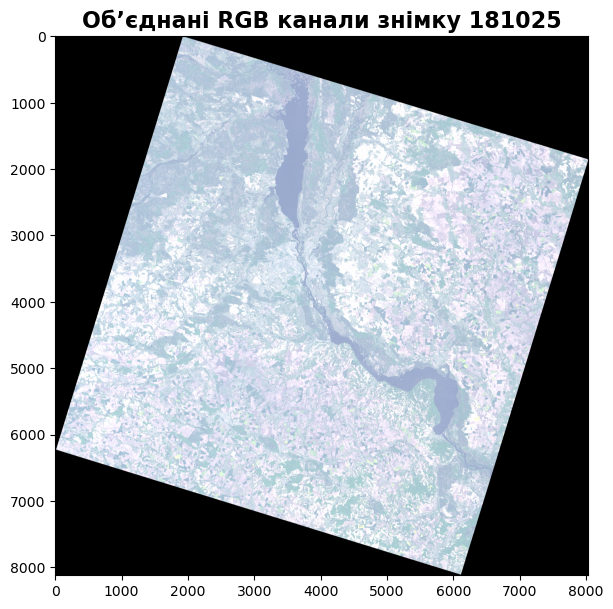

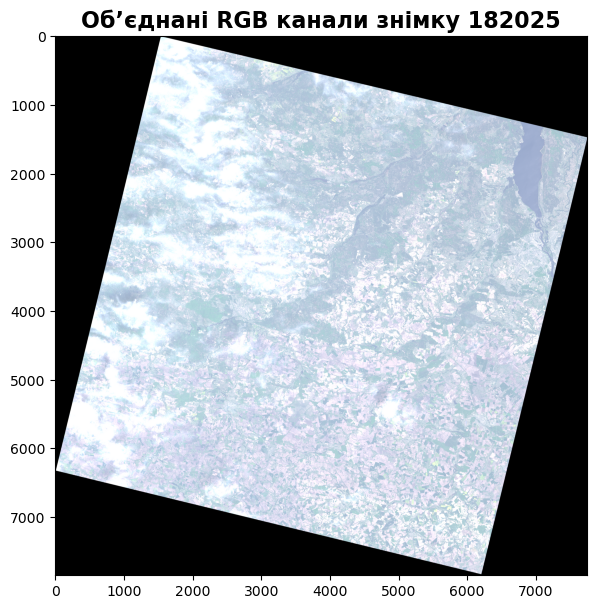

In [ ]:
# RGB лише для кожної сцени
bands_rgb = ["B2", "B3", "B4"]  # Blue, Green, Red
file_patterns = {
    "181025": "LC08_L1TP_181025_20240430_20240511_02_T1_{band}.TIF",
    "182025": "LC09_L1TP_182025_20240429_20240429_02_T1_{band}.TIF",
}
for d in landsat_dirs:
    basename = os.path.basename(d)
    pattern = file_patterns[basename]
    tif_files = [os.path.join(d, pattern.format(band=band)) for band in bands_rgb]
    missing = [f for f in tif_files if not os.path.exists(f)]
    if missing:
        print(f"Не знайдено файл(и): {missing}")
        continue

    output = os.path.join(d, "rgb_stack.tif")
    merge_cmd = [
        "python", os.path.join(sys.prefix, "Scripts", "gdal_merge.py"),
        "-separate", "-o", output
    ] + tif_files
    subprocess.run(merge_cmd)
    print(f"Зконкатеновано RGB для {basename}: {output}")

# візуалізація RGB
for d in landsat_dirs:
    rgb_file = os.path.join(d, "rgb_stack.tif")
    try:
        with rasterio.open(rgb_file) as src:
            rgb = src.read([3, 2, 1])
            rgb_norm = np.clip(rgb.transpose(1, 2, 0) / 10000, 0, 1)
            plt.figure(figsize=(7, 7))
            plt.title(f"Об’єднані RGB канали знімку {os.path.basename(d)}", fontsize=16, weight='bold')
            plt.imshow(rgb_norm)
            plt.axis("on")
            plt.show()
    except Exception as e:
        print(f"Не вдалося відкрити {rgb_file}: {e}")


4. Переведення панхроматичного каналу в 30 м, а RGB каналу в 60 метрів.

Панхроматичний канал 30м: C:/Users/Hello/Documents/ad_lab7_t/Landset/181025\pan_30m.tif
RGB 60м: C:/Users/Hello/Documents/ad_lab7_t/Landset/181025\rgb_60m.tif
Панхроматичний канал 30м: C:/Users/Hello/Documents/ad_lab7_t/Landset/182025\pan_30m.tif
RGB 60м: C:/Users/Hello/Documents/ad_lab7_t/Landset/182025\rgb_60m.tif


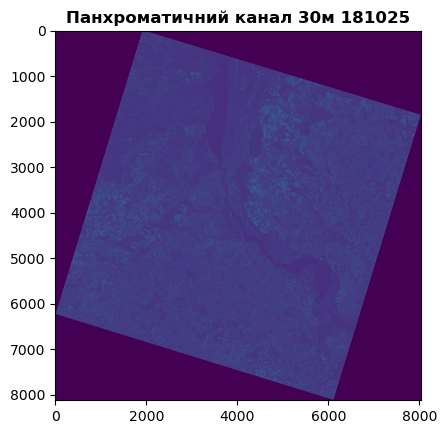

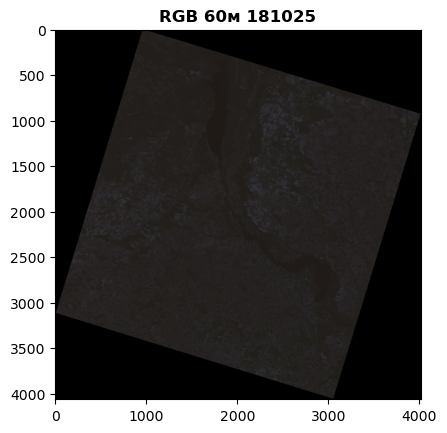

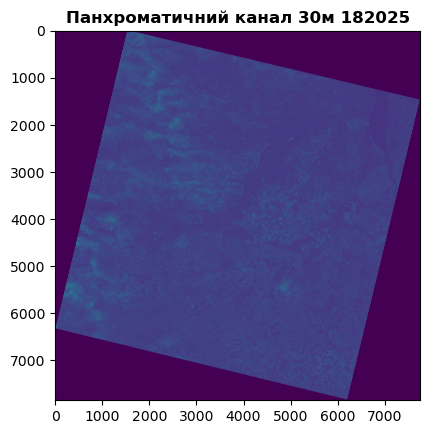

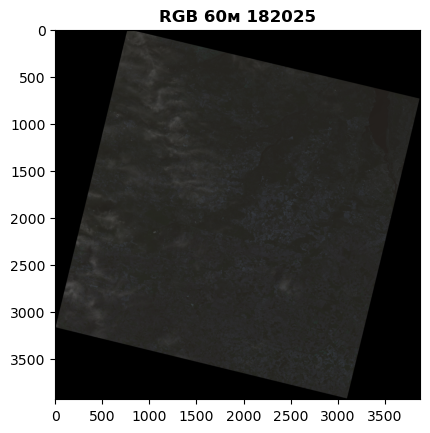

In [22]:
landsat_dirs = [
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/181025",
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/182025",
]
bands_rgb = ["B2", "B3", "B4"]
band_pan = "B8"

# 1. ресемплінг панхроматичного до 30 м, RGB до 60 м
for d in landsat_dirs:
    basename = os.path.basename(d)
    # панхроматичний (30м)
    pan_file = os.path.join(d, f"LC08_L1TP_{basename}_20240430_20240511_02_T1_{band_pan}.TIF") if "181025" in basename else \
               os.path.join(d, f"LC09_L1TP_{basename}_20240429_20240429_02_T1_{band_pan}.TIF")
    pan_30m = os.path.join(d, "pan_30m.tif")
    cmd30 = ["gdal_translate", "-tr", "30", "30", pan_file, pan_30m]
    subprocess.run(cmd30)
    print(f"Панхроматичний канал 30м: {pan_30m}")
    # RGB (60м)
    rgb_stack = os.path.join(d, "scene_stack.tif")
    rgb_60m = os.path.join(d, "rgb_60m.tif")
    cmd60 = ["gdal_translate", "-tr", "60", "60", rgb_stack, rgb_60m]
    subprocess.run(cmd60)
    print(f"RGB 60м: {rgb_60m}")

# 2. візуалізація ресемплених каналів
for d in landsat_dirs:
    try:
        with rasterio.open(os.path.join(d, "pan_30m.tif")) as pan_rast:
            show(pan_rast.read(1), title=f"Панхроматичний канал 30м {os.path.basename(d)}", adjust=True)
        with rasterio.open(os.path.join(d, "rgb_60m.tif")) as rgb_rast:
            show(rgb_rast.read([1, 2, 3]), title=f"RGB 60м {os.path.basename(d)}", adjust=True)
    except Exception as e:
        print(f"Помилка відкриття каналів для {d}: {e}")

паншарпінг 60м RGB через 30м панхром

CMD: python d:\anaconda\envs\lab7\Scripts\gdal_pansharpen.py -of GTiff -r nearest C:/Users/Hello/Documents/ad_lab7_t/Landset/181025\pan_30m.tif C:/Users/Hello/Documents/ad_lab7_t/Landset/181025\rgb_60m.tif C:/Users/Hello/Documents/ad_lab7_t/Landset/181025\pansharpened_30m.tif
Паншарп: C:/Users/Hello/Documents/ad_lab7_t/Landset/181025\pansharpened_30m.tif


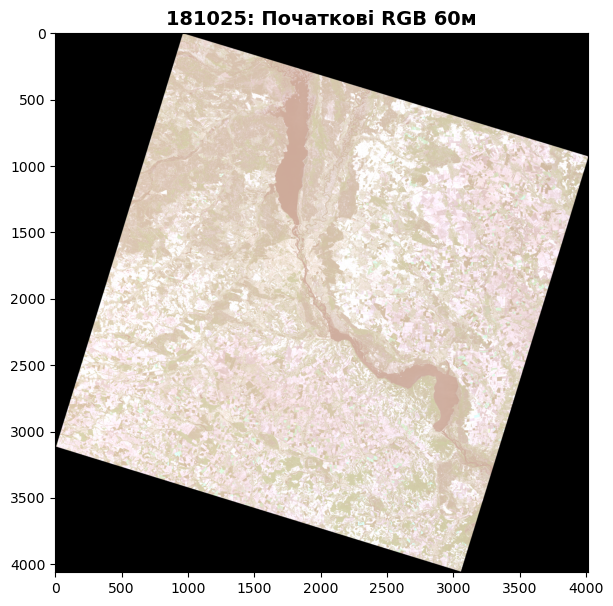

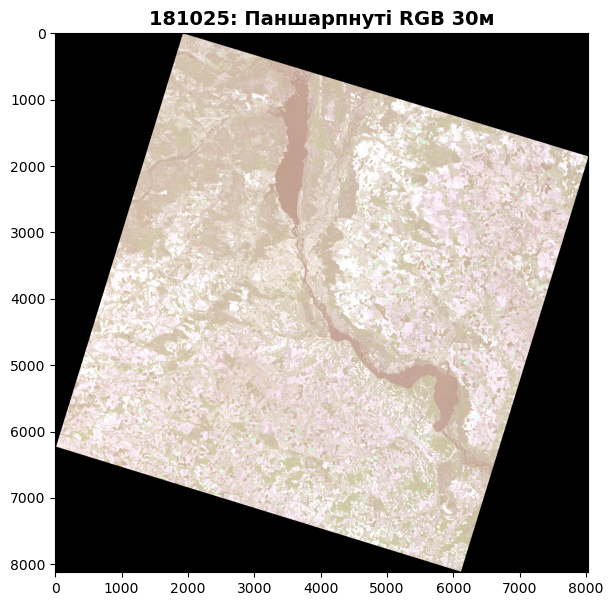

CMD: python d:\anaconda\envs\lab7\Scripts\gdal_pansharpen.py -of GTiff -r nearest C:/Users/Hello/Documents/ad_lab7_t/Landset/182025\pan_30m.tif C:/Users/Hello/Documents/ad_lab7_t/Landset/182025\rgb_60m.tif C:/Users/Hello/Documents/ad_lab7_t/Landset/182025\pansharpened_30m.tif
Паншарп: C:/Users/Hello/Documents/ad_lab7_t/Landset/182025\pansharpened_30m.tif


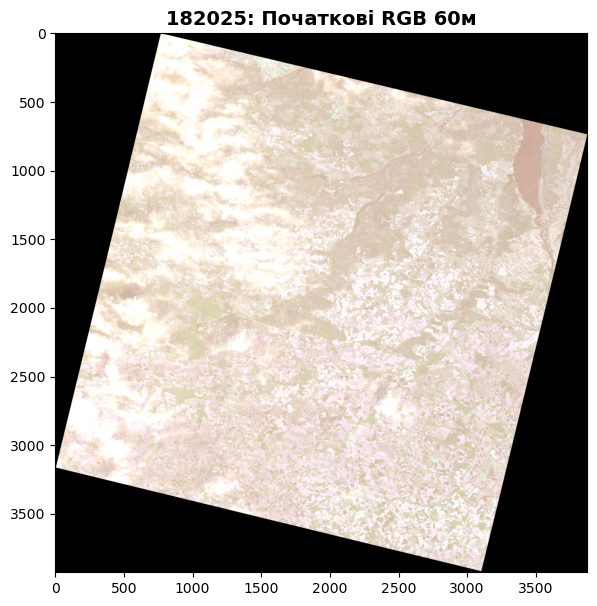

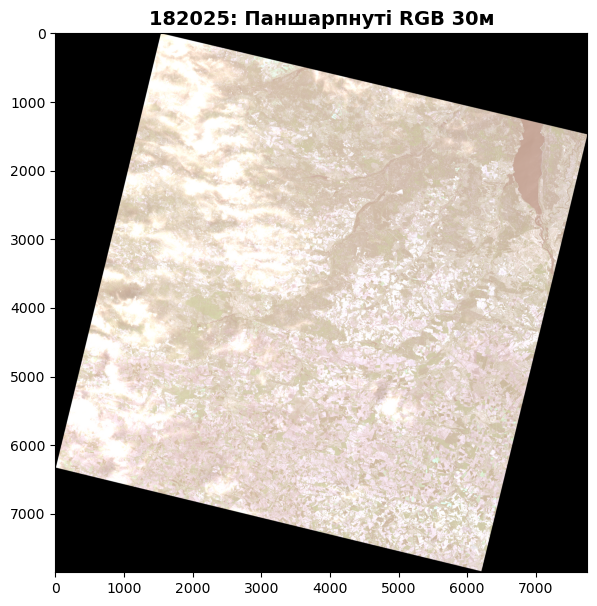

In [27]:
# 3. паншарпінг 60м RGB через 30м панхром (nearest)

landsat_dirs = [
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/181025",
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/182025",
]

for d in landsat_dirs:
    pan_30m = os.path.join(d, "pan_30m.tif")
    rgb_60m = os.path.join(d, "rgb_60m.tif")
    pansharp_out = os.path.join(d, "pansharpened_30m.tif")

    gdal_pansharpen = os.path.join(sys.prefix, "Scripts", "gdal_pansharpen.py")
    pansharpen_cmd = [
        "python", gdal_pansharpen, "-of", "GTiff", "-r", "nearest", pan_30m, rgb_60m, pansharp_out
    ]
    print("CMD:", " ".join(pansharpen_cmd))
    subprocess.run(pansharpen_cmd)
    print(f"Паншарп: {pansharp_out}")

    # візуалізація початкового RGB (60м)
    try:
        with rasterio.open(rgb_60m) as src:
            rgb = src.read([1, 2, 3])
            rgb_norm = np.clip(rgb.transpose(1, 2, 0) / 10000, 0, 1)
            plt.figure(figsize=(7, 7))
            plt.title(f"{os.path.basename(d)}: Початкові RGB 60м", fontsize=14, weight="bold")
            plt.imshow(rgb_norm)
            plt.axis("on")
            plt.show()
    except Exception as e:
        print(f"Не вдалося відкрити {rgb_60m}: {e}")

    # візуалізація паншарпнутих RGB (30м)
    try:
        with rasterio.open(pansharp_out) as src:
            rgb = src.read([1, 2, 3])
            rgb_norm = np.clip(rgb.transpose(1, 2, 0) / 10000, 0, 1)
            plt.figure(figsize=(7, 7))
            plt.title(f"{os.path.basename(d)}: Паншарпнуті RGB 30м", fontsize=14, weight="bold")
            plt.imshow(rgb_norm)
            plt.axis("on")
            plt.show()
    except Exception as e:
        print(f"Не вдалося відкрити {pansharp_out}: {e}")

5. Підрахування метрики точності паншарпенінгу. За даними метриками можемо побачити та визначити найкращий метод паншарпенінгу.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

landsat_dirs = [
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/181025",
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/182025",
]

methods = ['average', 'nearest', 'bilinear', 'cubic', 'cubicspline', 'lanczos']

def resize(input_file, output_file, width, height):
    cmd = [
        "gdal_translate",
        "-of", "GTiff",
        "-outsize", str(width), str(height),
        input_file, output_file
    ]
    subprocess.run(cmd)

def pansharpening(method, pan_file, rgb_file, output_file):
    gdal_pansharpen = os.path.join(sys.prefix, "Scripts", "gdal_pansharpen.py")
    cmd = [
        "python", gdal_pansharpen, "-of", "GTiff", "-r", method,
        pan_file, rgb_file, output_file
    ]
    subprocess.run(cmd)

def read(file_path):
    with rasterio.open(file_path) as src:
        data = src.read()
        return data.flatten(), src.shape

def calculate(original, pansharpened):
    mse = mean_squared_error(original, pansharpened)
    r2 = r2_score(original, pansharpened)
    return mse, r2

metrics = {}

for method in methods:
    mse_values = []
    r2_values = []
    for d in landsat_dirs:
        pan_file = os.path.join(d, "pan_30m.tif")
        rgb_file = os.path.join(d, "rgb_60m.tif")
        #  цільові розміри по панхроматичному каналу
        with rasterio.open(pan_file) as pan_src:
            width, height = pan_src.width, pan_src.height
        resized_rgb_file = os.path.join(d, "rgb_60m_resized.tif")
        resize(rgb_file, resized_rgb_file, width, height)
        pansharp_file = os.path.join(d, f"pansharpened_{method}_30m.tif")
        pansharpening(method, pan_file, resized_rgb_file, pansharp_file)
        # зчитування і обрахунок метрик
        original_rgb, _ = read(resized_rgb_file)
        pansharpened_rgb, _ = read(pansharp_file)
        mse, r2 = calculate(original_rgb, pansharpened_rgb)
        mse_values.append(mse)
        r2_values.append(r2)
    metrics[method] = {'MSE': np.mean(mse_values), 'R^2': np.mean(r2_values)}

print("Метрики точності для паншарпнутих зображень:")
for method, metric in metrics.items():
    print(f"\nМетод: {method}")
    print(f"  Середнє MSE: {metric['MSE']}")
    print(f"  Середнє R^2: {metric['R^2']}")

min_mse = min(metric['MSE'] for metric in metrics.values())
for method in metrics:
    if metrics[method]['MSE'] == min_mse:
        best_method = method
        break

print(f"\nНайкращий метод паншарпенінгу: {best_method} з середнім MSE: {min_mse}")

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

landsat_dirs = [
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/181025",
    "C:/Users/Hello/Documents/ad_lab7_t/Landset/182025",
]

methods = ['average', 'nearest', 'bilinear', 'cubic', 'cubicspline', 'lanczos']

def resize(input_file, output_file, width, height):
    cmd = [
        "gdal_translate",
        "-of", "GTiff",
        "-outsize", str(width), str(height),
        input_file, output_file
    ]
    subprocess.run(cmd)

def pansharpening(method, pan_file, rgb_file, output_file):
    gdal_pansharpen = os.path.join(sys.prefix, "Scripts", "gdal_pansharpen.py")
    cmd = [
        "python", gdal_pansharpen, "-of", "GTiff", "-r", method,
        pan_file, rgb_file, output_file
    ]
    subprocess.run(cmd)

def read(file_path):
    with rasterio.open(file_path) as src:
        data = src.read()
        return data.flatten(), src.shape

def calculate(original, pansharpened):
    mse = mean_squared_error(original, pansharpened)
    r2 = r2_score(original, pansharpened)
    return mse, r2

metrics = {}

for method in methods:
    mse_values = []
    r2_values = []
    for d in landsat_dirs:
        pan_file = os.path.join(d, "pan_30m.tif")
        rgb_file = os.path.join(d, "rgb_60m.tif")
        # дізнаємось цільові розміри по панхроматичному каналу
        with rasterio.open(pan_file) as pan_src:
            width, height = pan_src.width, pan_src.height
        resized_rgb_file = os.path.join(d, "rgb_60m_resized.tif")
        resize(rgb_file, resized_rgb_file, width, height)
        pansharp_file = os.path.join(d, f"pansharpened_{method}_30m.tif")
        pansharpening(method, pan_file, resized_rgb_file, pansharp_file)
        # зчитування і обрахунок метрик
        original_rgb, _ = read(resized_rgb_file)
        pansharpened_rgb, _ = read(pansharp_file)
        mse, r2 = calculate(original_rgb, pansharpened_rgb)
        mse_values.append(mse)
        r2_values.append(r2)
    metrics[method] = {'MSE': np.mean(mse_values), 'R^2': np.mean(r2_values)}

print("Метрики точності для паншарпнутих зображень:")
for method, metric in metrics.items():
    print(f"\nМетод: {method}")
    print(f"  Середнє MSE: {metric['MSE']}")
    print(f"  Середнє R^2: {metric['R^2']}")

min_mse = min(metric['MSE'] for metric in metrics.values())
for method in metrics:
    if metrics[method]['MSE'] == min_mse:
        best_method = method
        break

print(f"\nНайкращий метод паншарпенінгу: {best_method} з середнім MSE: {min_mse}")